In [ ]:
#%load_ext cudf.pandas
import joblib
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import holidays
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')


In [ ]:
'''#For kaggle, GPT-4 suggests:
from flask import Flask, jsonify
import kaggle

app = Flask(__name__)

@app.route('/datasets', methods=['GET'])
def get_datasets():
    # This is a basic example. You should add error handling and more specific functionality.
    datasets = kaggle.api.datasets_list()  # Use Kaggle's API to get dataset info
    return jsonify(datasets)

if __name__ == '__main__':
    app.run(debug=True)'''

In [ ]:
#Functions
def reference_score(true_values, predicted_values):
    score = mean_absolute_error(true_values, predicted_values)
    return score


def apply_dbscan_clustering(df, columns):
    # Check if columns are in the DataFrame
    if not all(col in df.columns for col in columns):
        raise ValueError("One or more specified columns are not in the DataFrame")

    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[columns])

    # Apply DBSCAN clustering
    dbscan = DBSCAN()
    clusters = dbscan.fit_predict(scaled_data)

    # Add cluster labels to the DataFrame
    df['cluster_label'] = clusters

    return df, dbscan, scaler

# Example usage:
# df = pd.read_csv('your_data.csv')
# clustered_df, trained_dbscan, scaler = apply_dbscan_clustering(df, ['column1', 'column2'])

def predict_dbscan_clusters(new_df, columns, trained_dbscan, scaler):
    # Check if columns are in the DataFrame
    if not all(col in new_df.columns for col in columns):
        raise ValueError("One or more specified columns are not in the DataFrame")

    # Standardizing the new data using the previously fitted scaler
    scaled_data = scaler.transform(new_df[columns])

    # Predict clusters using the trained DBSCAN model
    new_clusters = trained_dbscan.fit_predict(scaled_data)

    # Add cluster labels to the new DataFrame
    new_df['predicted_cluster_label'] = new_clusters

    return new_df

# Example usage:
# new_df = pd.read_csv('new_data.csv')
# predicted_df = predict_dbscan_clusters(new_df, ['column1', 'column2'], trained_dbscan, scaler)


def train_lstm(df, input_columns, output_column, N, M):
    # Create shifted columns for each input
    for col in input_columns:
        for n in range(1, N + 1):
            df[f'{col}_shifted_{n}'] = df[col].shift(n)

    # Create shifted columns for the output
    for m in range(1, M + 1):
        df[f'{output_column}_shifted_{m}'] = df[output_column].shift(m)

    # Drop rows with NaN values (due to shifting)
    df.dropna(inplace=True)

    # Separate the original output column
    original_output = df[output_column]

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df.drop(columns=[output_column]))

    # Prepare the dataset for the LSTM
    X = df_scaled
    y = original_output.values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Reshape input to be 3D [samples, timesteps, features] as required by LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)

    print(f'Model Score (MSE): {score}')
    return model, score, scaler

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here
# model, score, scaler = train_lstm(df, ['input1', 'input2'], 'output', N=3, M=1)


def test_lstm(model, scaler, df, input_columns, output_column, N, M):
    # Apply the same time shifts to input columns
    for col in input_columns:
        for n in range(1, N + 1):
            df[f'{col}_shifted_{n}'] = df[col].shift(n)

    # Apply the same time shifts to output column
    for m in range(1, M + 1):
        df[f'{output_column}_shifted_{m}'] = df[output_column].shift(m)

    # Drop rows with NaN values (due to shifting)
    df.dropna(inplace=True)

    # Standardize the data using the scaler from training
    df_scaled = scaler.transform(df.drop(columns=[output_column]))

    # Reshape input to be 3D as required by LSTM
    X = df_scaled.reshape((df_scaled.shape[0], 1, df_scaled.shape[1]))

    # Make predictions
    predictions = model.predict(X)
    return predictions

# Example usage:
# new_df = pd.read_csv('new_data.csv')  # Load new data
# predictions = test_lstm(trained_model, trained_scaler, new_df, ['input1', 'input2'], 'output', N=3, M=1)


# Importing and merging data
Here the [Kaggle dataset description](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/data).


In [ ]:
def check_frequency(df,dtcol):
    # Convert the 'datetime' column to a DatetimeIndex if it's not already
    df[dtcol] = pd.to_datetime(df[dtcol])

    # Set the 'datetime' column as the index of the DataFrame
    df = df.set_index(dtcol)

    # Infer the frequency of the DatetimeIndex
    frequency = pd.infer_freq(df.index[:100])  # Using a slice of the index to infer frequency

    print(f"The inferred frequency of the datetime column is: {frequency}")


def find_festives_estonia(df,datetime):
    es_holidays=holidays.Estonia()
    df['es_festive']=0
    for holiday in es_holidays:
        df['es_festive'].iloc[df[datetime]==holiday]=1
    return(df)

def lat_long_county(n,what='all',data_path=''):
    ##import weather_station_to_county_mapping!!
    #df=pd.read_csv(data_path+r'\weather_station_to_county_mapping.csv')
    #df=df.set_index('county')
    
    county_dict={0:"HARJUMAA",\
                 1:"HIIUMAA",\
                2:"IDA-VIRUMAA",\
                3:"J\u00c4RVAMAA",\
                4:"J\u00d5GEVAMAA",\
                5:"L\u00c4\u00c4NE-VIRUMAA",\
                6:"L\u00c4\u00c4NEMAA",\
                7:"P\u00c4RNUMAA",\
                8:"P\u00d5LVAMAA",\
                9:"RAPLAMAA",\
                10:"SAAREMAA",\
                11:"TARTUMAA",\
                12:"UNKNOWN",\
                13:"VALGAMAA",\
                14:"VILJANDIMAA",\
                15:"V\u00d5RUMAA"}
    df=pd.DataFrame(index=county_dict.keys(), columns=['lat','long'])

    df.loc[0]=[59.416665,24.749997]
    df.loc[1]=[58.923955,22.591947]
    df.loc[2]=[59.2166658,27.2999988]
    df.loc[3]=[58.8833298,25.5499978]
    df.loc[4]=[58.74667,26.39389]
    df.loc[5]=[59.32564740,26.63369150]
    df.loc[6]=[58.916663,23.749997]
    df.loc[7]=[58.38588,24.49711]
    df.loc[8]=[58.06028,27.06944]
    df.loc[9]=[59.00722,24.79278]
    df.loc[10]=[58.416665,22.583331]
    df.loc[11]=[58.378025, 26.728493]
    df.loc[13]=[57.77781,26.0473]
    df.loc[14]=[58.36389,25.59]
    df.loc[15]=[57.83389, 27.01944]
    df['lat'].loc[12]=df['lat'].mean()
    df['long'].loc[12]=df['long'].mean()
    '''
    for item in county_dict:
        df['county_name']=county_dict[item]
    '''
    if what=='all':
        res=df.loc[n]
    elif what=='lat':
        res=df.loc[n]
        res=res['lat']
    elif what=='long':
        res=df.loc[n]
        res=res['long']
    
    return(res)


def lat_long_all(data_path=''):
    ##import weather_station_to_county_mapping!!
    #df=pd.read_csv(data_path+r'\weather_station_to_county_mapping.csv')
    #df=df.set_index('county')
    colat='latitude'
    colong='longitude'
    county_dict={0:"HARJUMAA",\
                 1:"HIIUMAA",\
                2:"IDA-VIRUMAA",\
                3:"J\u00c4RVAMAA",\
                4:"J\u00d5GEVAMAA",\
                5:"L\u00c4\u00c4NE-VIRUMAA",\
                6:"L\u00c4\u00c4NEMAA",\
                7:"P\u00c4RNUMAA",\
                8:"P\u00d5LVAMAA",\
                9:"RAPLAMAA",\
                10:"SAAREMAA",\
                11:"TARTUMAA",\
                12:"UNKNOWN",\
                13:"VALGAMAA",\
                14:"VILJANDIMAA",\
                15:"V\u00d5RUMAA"}
    df=pd.DataFrame(index=county_dict.keys(), columns=[colat,colong])

    df.loc[0]=[59.416665,24.749997]
    df.loc[1]=[58.923955,22.591947]
    df.loc[2]=[59.2166658,27.2999988]
    df.loc[3]=[58.8833298,25.5499978]
    df.loc[4]=[58.74667,26.39389]
    df.loc[5]=[59.32564740,26.63369150]
    df.loc[6]=[58.916663,23.749997]
    df.loc[7]=[58.38588,24.49711]
    df.loc[8]=[58.06028,27.06944]
    df.loc[9]=[59.00722,24.79278]
    df.loc[10]=[58.416665,22.583331]
    df.loc[11]=[58.378025, 26.728493]
    df.loc[13]=[57.77781,26.0473]
    df.loc[14]=[58.36389,25.59]
    df.loc[15]=[57.83389, 27.01944]
    df[colat].loc[12]=df[colat].mean()
    df[colong].loc[12]=df[colong].mean()
    '''
    for item in county_dict:
        df['county_name']=county_dict[item]
    '''

    return(df)


def lat_county(n):
    lat=lat_long_county(n,what='lat')
    return(lat)

def long_county(n):
    long=lat_long_county(n,what='long')
    return(long)

    
    
def findClosest(arr, n, target):
    left, right = 0, n - 1
    while left < right:
        if abs(arr[left] - target) <= abs(arr[right] - target):
            right -= 1
        else:
            left += 1
    return (arr[left],arr[left+1])
def weighted_value(x,xm,xM,ym,yM):
    if x==xM or x==xm:
        y=(ym+yM)/2
    else:
        y=(x-xm)/(xM-xm)*(yM-ym)+ym
    y=np.round(y, 2)
    return(y)

def find_weather_on_lat_long_old(weather_df,lat,long,parameters_to_extract,parameters_to_keep,datetime='datetime',datetime2='datetime2',col_lat='latitude',col_long='longitude'):
    #find closest lat and long in forecast weather
    [latm,latM]=findClosest(weather_df.groupby(col_lat).mean().index,len(weather_df.groupby(col_lat).mean().index),lat)
    [lonm,lonM]=findClosest(weather_df.groupby(col_long).mean().index,len(weather_df.groupby(col_long).mean().index),long)
    #tmp_df is a dataframe containing all predictions for the little swquare latlong
    #Useful to avoid data out of bound. 
    temp_df=weather_df[weather_df[col_lat]>=latm]
    temp_df=temp_df[temp_df[col_lat]<=latM]
    temp_df=temp_df[temp_df[col_long]<=lonM]
    temp_df=temp_df[temp_df[col_long]>=lonm]
    #predictions are from different days. I need to account for datetime
    dates=temp_df.groupby(datetime).mean().index
    df=pd.DataFrame(index=dates,columns=parameters_to_extract+parameters_to_keep)



    for col in parameters_to_extract:
        df[col]=np.nan
        print(col)
        for data in dates:
            squared_data=temp_df[temp_df[datetime]==data]

            if len(squared_data)>4:
                #48 hours predictions mean that at midnight day 0 you have preds up to midnight3. Keep the latest. 
                indexlist=pd.to_datetime(squared_data[datetime2].values).day==np.max(pd.to_datetime(squared_data[datetime2].values).day)

                squared_data=squared_data.loc[indexlist]

            #find weighted parameter based on lat and long. Could be checked as below. 

            squared=squared_data[squared_data[col_long]==lonM]
            T1=weighted_value(lat,latm,latM,
                              squared[squared[col_lat]==latm][col].values,squared[squared[col_lat]==latM][col].values)

            squared=squared_data[squared_data[col_long]==lonm]

            T2=weighted_value(lat,latm,latM,squared[squared[col_lat]==latm][col].values,squared[squared[col_lat]==latM][col].values)
            #place in the right spot of temp the right value.
            df[col].loc[data]=weighted_value(long,lonm,lonM,float(T2),float(T1))
            for colkeep in parameters_to_keep:
                if colkeep==datetime:
                    df[colkeep]=data
                else:
                    df[colkeep]=squared_data[colkeep].iloc[0]
            df[col_lat]=lat
            df[col_long]=long
    #The final dataset contains one row per datetime and one column per parameter. 
    #Can me merged duplicating rows in the train dataset.
    return(df)
    '''
    temp3=temp2 in lat ==latM
    T3=weighted(lon,lonm,lonM,T@onm,T@lonM)
    temp3=temp2 in lon ==latm
    T4=weighted(lon,lonm,lonM,T@onm,T@lonM)
    Tref2=weighted(lat,latm,latM,T4,T3)

    if Tref1=! Tref2:
    Tref=mean(Tref1,Tref2)
    else print('ok')

    temp[col].iloc[data]=Tref
    '''
    
def find_weather_on_lat_long(weather_df, lat, long, parameters_to_extract, parameters_to_keep,
                             datetime='datetime', datetime2='datetime2', col_lat='latitude', col_long='longitude'):
    # Precomputed groups (call these outside and pass them to the function if they don't change)
    lat_group = weather_df.groupby(col_lat).mean().index
    long_group = weather_df.groupby(col_long).mean().index

    [latm, latM] = findClosest(lat_group, len(lat_group), lat)
    [lonm, lonM] = findClosest(long_group, len(long_group), long)

    # Filter the DataFrame in a single step
    temp_df = weather_df[(weather_df[col_lat].between(latm, latM)) & (weather_df[col_long].between(lonm, lonM))]

    # Create DataFrame
    dates = temp_df.groupby(datetime).mean().index
    df = pd.DataFrame(index=dates, columns=parameters_to_extract + parameters_to_keep)
    
    for col in parameters_to_extract:
        print('Extracting {}'.format(col))
        df[col] = np.nan
        for data in dates:
            squared_data = temp_df[temp_df[datetime] == data]

            if len(squared_data) > 4:
                max_day = pd.to_datetime(squared_data[datetime2].values).day.max()
                squared_data = squared_data[pd.to_datetime(squared_data[datetime2].values).day == max_day]

            for col_long_val in [lonm, lonM]:
                squared = squared_data[squared_data[col_long] == col_long_val]
                T = weighted_value(lat, latm, latM,
                                   squared[squared[col_lat] == latm][col].values,
                                   squared[squared[col_lat] == latM][col].values)
                df.at[data, col] = T if col_long_val == lonm else weighted_value(long, lonm, lonM, float(T), float(df.at[data, col]))
            
            for colkeep in parameters_to_keep:
                if colkeep == datetime:
                    df[colkeep] = data
                else:
                    df[colkeep] = squared_data[colkeep].iloc[0]

            df[col_lat] = lat
            df[col_long] = long

    return df

def merge_weather_and_train(train,weather_df,lat_lon_data_train,lat_lon_data_w):
    #lists of columns should contain in the right order:
    # latitude,longitude,data.
    #the function merges rows which have the same lat and long and same data 
    # - they are alla vailable in same time and same space. The dat ablock id is not taken into consderation yet.
    train['mergecolumn']=np.nan
    weather_df['mergecolumn']=np.nan
    for index in train.index:
        tempdt=pd.to_datetime(train[lat_lon_data_train[2]].loc[index])
        val='{}{}{}{}'.format(tempdt.year,tempdt.month,tempdt.day,tempdt.hour)
        train['mergecolumn'].loc[index]='{}_{}_{}'.\
            format(train[lat_lon_data_train[0]].loc[index],
                   train[lat_lon_data_train[1]].loc[index],
                   val)
    try:
        weather_df=weather_df.drop(columns=[lat_lon_data_w[2]])
    except:
        print('No duplicates')
    weather_df=weather_df.reset_index(allow_duplicates=True)
    for index in weather_df.index:
        tempdt=pd.to_datetime(weather_df[lat_lon_data_w[2]].loc[index])
        val='{}{}{}{}'.format(tempdt.year,tempdt.month,tempdt.day,tempdt.hour)
        weather_df['mergecolumn'].loc[index]='{}_{}_{}'.\
            format(weather_df[lat_lon_data_w[0]].loc[index],
                   weather_df[lat_lon_data_w[1]].loc[index],
                   val)

    merged_df = pd.merge(train, weather_df, on=['mergecolumn'], how='inner')

    #merged_df=merged_df.drop_duplicates(subset=[data], keep='first', inplace=True, ignore_index=True)

    #merged_df=merged_df.drop(['mergecolumn'], axis=1)

    return(merged_df)


def generate_dataframe(init_df,col,item):
    df=init_df[init_df[col]==item]
    return(df)



### train.csv

- *county* - An ID code for the county.
- *is_business* - Boolean for whether or not the prosumer is a business.
- *product_type* - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- *target* - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- *is_consumption* - Boolean for whether or not this row's target is consumption or production.
- *datetime* - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- *data_block_id* - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- *row_id* - A unique identifier for the row.
- *prediction_unit_id* - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

*prediction_unit_id* should not be used as input as it changes. 
It is interesting to understand if the physical behaviour is influenced by county, business and product type: uding a clustering and exluding those infos, then checking if clusters overlap with the items will give us some additiona infos.

### client.csv

- *product_type*
- *county* - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
- *eic_count* - The aggregated number of consumption points (EICs - European Identifier Code).
- *installed_capacity* - Installed photovoltaic solar panel capacity in kilowatts.
- *is_business* - Boolean for whether or not the prosumer is a business.
- *date*
- *data_block_id*

Installed capacity can be used to normalize production data. Production type, county and is business as well as data block id shoudl match the previous. 
To match client to train, we need to remap *prediction_unit_id* by finding county+productiontype+biz in the train dataset.

### electricity_prices.csv

- *origin_date*
- *forecast_date*
- *euros_per_mwh* - The price of electricity on the day ahead markets in euros per megawatt hour.
- *data_block_id*

How should prices will help me?

### forecast_weather.csv 
Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

- *[latitude/longitude]* - The coordinates of the weather forecast.
- *origin_datetime* - The timestamp of when the forecast was generated.
- *hours_ahead* - The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- *temperature* - The air temperature at 2 meters above ground in degrees Celsius.
- *dewpoint* - The dew point temperature at 2 meters above ground in degrees Celsius.
- *cloudcover_[low/mid/high/total]* - The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
- *10_metre_[u/v]_wind_component* - The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second.
- *data_block_id*
- *forecast_datetime* - The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead.
- *direct_solar_radiation* - The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
- *surface_solar_radiation_downwards* - The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
- *snowfall* - Snowfall over the previous hour in units of meters of water equivalent.
- *total_precipitation* - The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.

### historical_weather.csv 
Historic weather data.

- *datetime*
- *temperature*
- *dewpoint*
- *rain* - Different from the forecast conventions. The rain from large scale weather systems of the preceding hour in millimeters.
- *snowfall* - Different from the forecast conventions. Snowfall over the preceding hour in centimeters.
- *surface_pressure* - The air pressure at surface in hectopascals.
- *cloudcover_[low/mid/high/total]* - Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- *windspeed_10m* - Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- *winddirection_10m* - Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- *shortwave_radiation* - Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- *direct_solar_radiation*
- *diffuse_radiation* - Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- *[latitude/longitude]* - The coordinates of the weather station.
- *data_block_id*

### Other data
*public_timeseries_testing_util*.py An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.

*example_test_files/* Data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three data_block_ids are repeats of the last three data_block_ids in the train set.

*example_test_files/sample_submission.csv* A valid sample submission, delivered by the API. See this notebook for a very simple example of how to use the sample submission.

*example_test_files/revealed_targets.csv* The actual target values from the day before the forecast time. This amounts to two days of lag relative to the prediction times in the test.csv.

*enefit/* Files that enable the API. Expect the API to deliver all rows in under 15 minutes and to reserve less than 0.5 GB of memory. The copy of the API that you can download serves the data from example_test_files/. You must make predictions for those dates in order to advance the API but those predictions are not scored. Expect to see roughly three months of data delivered initially and up to ten months of data by the end of the forecasting period.



In [ ]:

###MAIN###

data_path=r'C:\Users\Mipu_10\Documents\GitHub\kaggle_enefit_prosumer_forecasting\predict-energy-behavior-of-prosumers'
train=pd.read_csv(data_path+r'\train.csv')
client=pd.read_csv(data_path+r'\client.csv')



In [ ]:

#order the train dataset based on prediction_unit_id
train=train.sort_values('prediction_unit_id')

#Split consumption and generation
consumption=generate_dataframe(train,'is_consumption',1)
production=generate_dataframe(train,'is_consumption',0)

consumption_b=generate_dataframe(consumption,'is_business',1)
consumption_c=generate_dataframe(consumption,'is_business',0)
production_b=generate_dataframe(production,'is_business',1)
production_c=generate_dataframe(production,'is_business',0)

In [ ]:
#items of dictionary, will contain one dataframe per single production unit. Easier to manage. 
#dividing in 4 df is faster coz we donot work on very big dataframes. 

dfs=[consumption_b,consumption_c,production_b,production_c]
what=['cb','cc','pb','pc']
dict={}
ii=0
for df in dfs:
    puis=df.groupby('prediction_unit_id').mean().index
    
    final_df=pd.DataFrame()
    iters=0
    for pui in puis:
        temp=df[df['prediction_unit_id']==pui]
        temp=temp.sort_values('datetime')
        temp['datetime']=pd.to_datetime(temp['datetime'])
        temp['weekday']=pd.to_datetime(temp['datetime'].values).weekday
        temp['hour_of_day']=pd.to_datetime(temp['datetime'].values).hour
        temp['day_of_month']=pd.to_datetime(temp['datetime'].values).day
        temp['month']=pd.to_datetime(temp['datetime'].values).month
        temp['date']=pd.to_datetime(temp['datetime'].values).date
        temp=find_festives_estonia(temp,'datetime')
        '''
        if iters==0:
            last=temp
            iters=1
        else:
            last=pd.concat([last,temp])
        '''
        dict['{}'.format(pui)]=temp
        ii=ii+1
    
#To avoid memory error, should truncate based on prediction unit or datetime. 
#Probably, the best thing to do is managing one prediction unit per time, and then batch training. 
for pui in dict: 
    print('--- Doing prediction unit {}'.format(pui))
    df=dict[pui]
    ttt='{}_{}_{}'.format('product_type','county','is_business')
    client[ttt]=client['product_type']*100+client['county']*10+client['is_business']
    df[ttt]=df['product_type']*100+df['county']*10+df['is_business']
    iters=0
    
    #if dict contains one pui, this is useless. 
    #puis=df.groupby(ttt).mean().index
    #N=3 #how many puis? max=len(puis)
    
    cols_to_import=['eic_count','installed_capacity','data_block_id',ttt]
    #max_datetime=pd.to_datetime('2021-11-01 00:00:00')
    #truncated_df=df[df['datetime']<max_datetime]
    #for pui in puis[0:N]:

    #dfpui=truncated_df[truncated_df[ttt]==pui]
    clientpui=client[client[ttt]==pui][cols_to_import]
    #tempmerged=pd.merge(dfpui,clientpui,on=ttt,how='left')
    tempmerged=pd.merge(df,clientpui,on=ttt,how='left')
    tempmerged=tempmerged.drop_duplicates(subset=['datetime'])
    '''
    if iters==0:
        merged=tempmerged
        iters=1
    else:
        merged=pd.concat([merged,tempmerged])
    '''
    dict[pui]=tempmerged
 

In [ ]:
forecast_weather=pd.read_csv(data_path+r'\forecast_weather.csv')
historical_weather=pd.read_csv(data_path+r'\historical_weather.csv')
electricity_prices=pd.read_csv(data_path+r'\electricity_prices.csv')

for col in forecast_weather.columns:
    forecast_weather=forecast_weather.rename(columns={col: "{}_f".format(col)})
    
for col in historical_weather.columns:
    historical_weather=historical_weather.rename(columns={col: "{}_h".format(col)})
    
electricity_prices['forecast_date']=pd.to_datetime(electricity_prices['forecast_date'])

In [ ]:
#create the final dataframe. 
all_h_w_cols=['datetime_h', 'temperature_h', 'dewpoint_h', 'rain_h', 'snowfall_h',
       'surface_pressure_h', 'cloudcover_total_h', 'cloudcover_low_h',
       'cloudcover_mid_h', 'cloudcover_high_h', 'windspeed_10m_h',
       'winddirection_10m_h', 'shortwave_radiation_h',
       'direct_solar_radiation_h', 'diffuse_radiation_h', 'latitude_h',
       'longitude_h', 'data_block_id_h']

all_f_w_cols=['latitude_f', 'longitude_f', 'origin_datetime_f', 'hours_ahead_f',
       'temperature_f', 'dewpoint_f', 'cloudcover_high_f', 'cloudcover_low_f',
       'cloudcover_mid_f', 'cloudcover_total_f', '10_metre_u_wind_component_f',
       '10_metre_v_wind_component_f', 'data_block_id_f', 'forecast_datetime_f',
       'direct_solar_radiation_f', 'surface_solar_radiation_downwards_f',
       'snowfall_f', 'total_precipitation_f']


final_dict={}
colslat=['latitude','longitude']
test_f=0
test_h=0
#item='cb'

counties=train.groupby('county').mean().index
lldf=lat_long_all() #contains one index per county, latitude and longitude columns. 

#max_datetime=pd.to_datetime('2021-11-01 00:00:00')
#df=tot_df[tot_df['datetime']<max_datetime]
'''
for row in df.index:
    try:
        df[colslat[0]].iloc[row],df[colslat[1]].iloc[row]=lat_long_county(df['county'].iloc[row])
    except:
        df[colslat[0]].iloc[row],df[colslat[1]].iloc[row]=lat_long_county(df['county'].iloc[row].values)
'''
print('I created lats and longs. Exploring weather.')

#puis=df.groupby('prediction_unit_id').mean().index

#df=df[df['prediction_unit_id']==puis[0]]

lats=lldf.groupby('latitude').mean().index

for lat in lats:
    lons=lldf[lldf['latitude']==lat].groupby('longitude').mean().index
    for long in lons:
        print('{} and {}'.format(lat,long))
        #find the dataset with all items at right lat and lon. 

        #forecasted
        fweather_df=find_weather_on_lat_long(forecast_weather,lat,long,parameters_to_extract_f,parameters_to_keep_f,
                                             datetime='forecast_datetime_f',datetime2='origin_datetime_f',col_lat='latitude_f',
                                             col_long='longitude_f')
        if test_f==0:
            right_weather_forecast=fweather_df
            test_f=1
        else:
            right_weather_forecast=pd.concat([right_weather_forecast,fweather_df])


        #historical 
        hweather_df=find_weather_on_lat_long(historical_weather,lat,long,parameters_to_extract_h,parameters_to_keep_h,
                                             datetime='datetime_h',datetime2='datetime_h',col_lat='latitude_h',
                                             col_long='longitude_h')
        if test_h==0:
            right_weather_history=hweather_df
            test_h=1
        else:
            right_weather_history=pd.concat([right_weather_history,hweather_df])
            display(right_weather_history)


        print('Found parameters for {} and {}'.format(lat,long))
        #merge the right dweather df with train df

        
###--->> https://www.digitalocean.com/community/tutorials/pandas-dataframe-apply-examples impara qui a usarlo
        
        
right_weather_forecast=right_weather_forecast.rename(columns={"datetime_h": "datetime_h_original"})
right_weather_history=right_weather_history.rename(columns={"forecast_datetime_f": "forecast_datetime_f_original"})

right_weather_forecast.to_pickle("./right_weather_forecast.pkl")
right_weather_history.to_pickle("./right_weather_history.pkl") 

In [ ]:


#forecast
parameters_to_extract_f=['temperature_f', 'dewpoint_f', 'cloudcover_high_f', 'cloudcover_low_f',
   'cloudcover_mid_f', 'cloudcover_total_f', '10_metre_u_wind_component_f',
   '10_metre_v_wind_component_f','direct_solar_radiation_f', 'surface_solar_radiation_downwards_f',
   'snowfall_f', 'total_precipitation_f']

parameters_to_keep_f=['latitude_f', 'longitude_f', 'origin_datetime_f', 
                    'hours_ahead_f','data_block_id_f', 'forecast_datetime_f']#these need to be kept not weighted!

#historical
parameters_to_extract_h=['temperature_h', 'dewpoint_h', 'rain_h', 'snowfall_h',
   'surface_pressure_h', 'cloudcover_total_h', 'cloudcover_low_h',
   'cloudcover_mid_h', 'cloudcover_high_h', 'windspeed_10m_h',
   'winddirection_10m_h', 'shortwave_radiation_h',
   'direct_solar_radiation_h', 'diffuse_radiation_h']

parameters_to_keep_h=['latitude_h', 'longitude_h', 'datetime_h', 
                    'data_block_id_h']




    


In [ ]:
lat_lon_data_train=['latitude','longitude','datetime']
lat_lon_data_f=['latitude_f','longitude_f','forecast_datetime_f']
lat_lon_data_h=['latitude_h','longitude_h','datetime_h']
lat_lon_data_all=lat_lon_data_train+lat_lon_data_f
for pui in dict:
#pui=list(dict.keys())[0]
    print('Doing {}'.format(pui))
    df=dict[pui]
    print('Defining lat and long')

    df['latitude']=df['county']
    df['latitude']= df['county'].apply(lat_county)


    df['longitude']=df['county']
    df['longitude'] = df['county'].apply(long_county)
    
    right_weather_forecast[lat_lon_data_f[2]]=pd.to_datetime(right_weather_forecast.index)
    right_weather_history[lat_lon_data_h[2]]=pd.to_datetime(right_weather_history.index)

    tempp=merge_weather_and_train(df,right_weather_forecast,lat_lon_data_train,lat_lon_data_f)
    final_dict[pui]=merge_weather_and_train(tempp,right_weather_history,lat_lon_data_all,lat_lon_data_h)
    final_dict[pui]=pd.merge(final_dict[pui], electricity_prices,  
                               how='left', left_on=['datetime'], right_on = ['forecast_date'])
    display(final_dict[pui])
    print('finished merging {}.'.format(pui))
    joblib.dump(final_dict, "./final_dict.pkl")

In [ ]:

#if needed, load final dict.
final_dict=joblib.load(r"./final_dict.pkl")
print('loaded!')
target_shifts=24
norm='target_normalized'
cols_to_shift_hourly=[norm,'temperature_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'direct_solar_radiation_f',
'snowfall_f',
'total_precipitation_f']
cols_to_shift_daily=['es_festive']

for pui in final_dict:
    
    df=final_dict[pui]
    df=df.sort_values('datetime')
    df[norm]=df['target']/df['installed_capacity']
    for shift in range(1,target_shifts+1):
        for col in cols_to_shift_hourly:
            df['{}_{}'.format(col,shift)]=df[col].shift(shift)
            df['{}_{}'.format(col,shift)]=df[col].shift(shift)
    for col in cols_to_shift_daily:
        df['{}_{}'.format(col,shift)]=df[col].shift(target_shifts+1)
    final_dict[pui]=df
print('finished!')
joblib.dump(final_dict, "./train_dataset_complete.pkl")
print('saved!')
'''
Next:
 - target shifts
 - correlation matrix
 - scatterplots
 - training!
'''

In [ ]:
joblib.dump(final_dict, "./train_dataset_complete.pkl")
print('saved!')
for col in df.columns:
    print("'{}',".format(col))

In [149]:
print(final_dict.keys())

dict_keys(['3', '4', '5', '8', '10', '13', '14', '17', '18', '21', '22', '23', '24', '28', '29', '30', '33', '36', '37', '40', '41', '42', '46', '47', '48', '49', '52', '55', '56', '59', '60', '61', '63', '64', '65', '66', '67', '68', '0', '1', '2', '6', '7', '9', '11', '12', '15', '16', '19', '20', '25', '26', '27', '31', '32', '34', '35', '38', '39', '43', '44', '45', '50', '51', '53', '54', '57', '58', '62'])


<IPython.core.display.Javascript object>


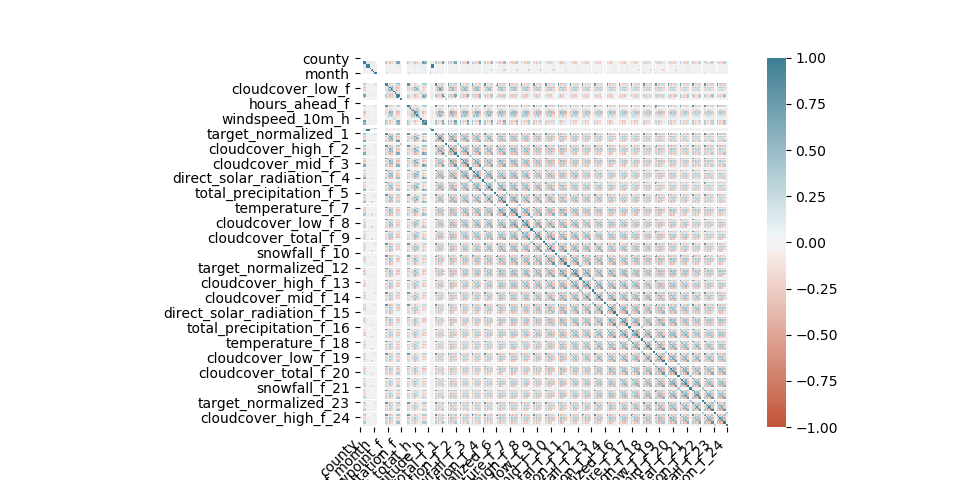

In [151]:
import seaborn as sns
pui='5'

df=final_dict[pui]
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
plt.close('all')
tipos=trainpb.groupby('county').mean().index
for tipo in tipos:
    tmp=trainpb[trainpb['county']==tipo]
    plt.scatter(trainpb['installed_capacity'],trainpb['target'],label=tipo,alpha=0.2)
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


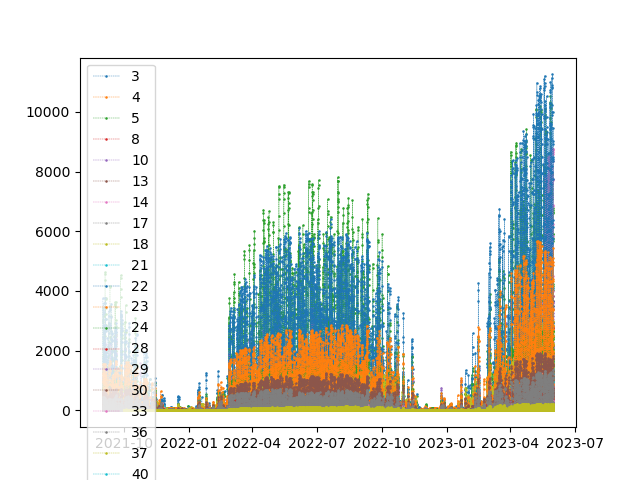

In [152]:
%matplotlib notebook
plt.close('all')
for item in final_dict:
    df=dict[item]
    df=df.sort_values('datetime')
    plt.plot(df['datetime'],df['target'],label=item,markersize=0.8,marker='o', linestyle='dashed',
     linewidth=0.3)
    plt.legend()
plt.show()


In [ ]:
plt.close('all')

trainpb=trainpb.sort_values('datetime')
puis=trainpb.groupby('prediction_unit_id').mean().index
for pui in puis:
    df=trainpb[trainpb['prediction_unit_id']==pui]
    plt.plot(df['datetime'],df['target']/df['installed_capacity'],label=pui)

plt.show()

In [ ]:
plt.close('all')
tipos=client.groupby('county').mean().index
for tipo in tipos:
    tmp=client[client['county']==tipo]
    plt.scatter(client['eic_count'],client['installed_capacity'],label=tipo,alpha=0.2)
plt.legend()
plt.show()

#no correlation btw all info in client.  

In [ ]:
plt.close('all')

trainpb=trainpb.sort_values('datetime')
puis=trainpb.groupby('prediction_unit_id').mean().index
for pui in puis:
    df=trainpb[trainpb['prediction_unit_id']==pui]
    plt.plot(df['datetime'],df['target'],label=pui)
plt.show()

In [ ]:
temp=train.groupby(['prediction_unit_id']).mean()
print(temp.index)
